In [1]:
# ---------------------------
# Cell 1: Clone & install
# ---------------------------
# Cloner le repo VIM (Vision Mamba)
!git clone https://github.com/hustvl/Vim.git /content/Vim || true

# Aller dans le sous-dossier "vim" où se trouve models_mamba.py
%cd /content/Vim/vim

# Installer les dépendances
# Le repo a parfois deux fichiers req; on tente les deux
!pip install -r ../vim/vim_requirements.txt || pip install -r vim_requirements.txt || true

# Installer les packages locaux en mode editable (pour imports internes)
%cd /content/Vim
!pip install -e ./mamba-1p1p1 || true
!pip install -e ./det || true
!pip install -e ./causal-conv1d || true

# Retour dans le dossier du modèle
%cd /content/Vim/vim

# quick check
print("PYTHONPATH preview (head):")
import sys
for p in sys.path[:5]:
    print(" -", p)

fatal: destination path '/content/Vim' already exists and is not an empty directory.
/content/Vim/vim
  Using cached addict-2.4.0-py3-none-any.whl.metadata (1.0 kB)
  Using cached aiohttp-3.9.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.4 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached alembic-1.13.0-py3-none-any.whl.metadata (7.4 kB)
  Using cached async_timeout-4.0.3-py3-none-any.whl.metadata (4.2 kB)
  Using cached attrs-23.1.0-py3-none-any.whl.metadata (11 kB)
  Using cached blinker-1.7.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached certifi-2023.11.17-py3-none-any.whl.metadata (2.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.2/156.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 8.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install torch torchvision torchaudio scikit-learn matplotlib seaborn tqdm Pillow

In [3]:
!rm -rf /content/drive
!mkdir /content/drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ---------------------------
# Cell 2: Imports & mount Google Drive
# ---------------------------
# Python imports
import os, random, time, glob, sys, json, yaml
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Monitoring / metrics
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Mount Google Drive (Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✅ Google Drive mounted")
except Exception as e:
    print("⚠️ Could not mount Drive (not Colab?) — continuing locally:", e)

# Ensure project paths are visible to Python (idempotent)
for p in ["/content/Vim/vim", "/content/Vim/mamba-1p1p1", "/content/Vim/causal-conv1d", "/content/Vim/det"]:
    if p not in sys.path:
        sys.path.insert(0, p)

print("Python version:", sys.version)
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Torch version: 2.9.0+cu126
CUDA available: True


In [ ]:
!ls /content/drive/MyDrive/dataset

In [5]:
# ---------------------------
# Cell 3: User settings
# ---------------------------
import os, yaml

# Chemin racine du dataset dans ton Google Drive
DATASET_ROOT = '/content/drive/MyDrive/dataset'

# Fichier data.yaml (il doit être dans le dossier dataset)
yaml_path = os.path.join(DATASET_ROOT, "data.yaml")

# Charger le YAML
with open(yaml_path, "r") as f:
    cfg = yaml.safe_load(f)

# Extraire les classes et le nombre
CLASS_NAMES = cfg["names"]
NUM_CLASSES = cfg["nc"]

print("✅ Classes trouvées:", CLASS_NAMES)
print("Nombre de classes:", NUM_CLASSES)

# Dossier de sortie pour checkpoints et résultats
OUTPUT_DIR = '/content/drive/MyDrive/thermal_model_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hyperparamètres d'entraînement
BATCH_SIZE   = 16
IMAGE_SIZE   = 224           # VIM attend du 224x224
NUM_EPOCHS   = 12
LEARNING_RATE= 1e-4
WEIGHT_DECAY = 1e-5
NUM_WORKERS  = 2
SEED         = 42
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)

✅ Classes trouvées: ['MultiByPassed', 'MultiDiode', 'MultiHotSpot', 'SingleByPassed', 'SingleDiode', 'SingleHotSpot', 'StringOpenCircuit', 'StringReversedPolarity']
Nombre de classes: 8
Device: cuda


In [6]:
# ---------------------------
# Cell 4: Build image/label pairs
# ---------------------------
import os

# Dossiers images et labels
train_img_dir   = os.path.join(DATASET_ROOT, "train", "images")
train_label_dir = os.path.join(DATASET_ROOT, "train", "labels")

valid_img_dir   = os.path.join(DATASET_ROOT, "valid", "images")
valid_label_dir = os.path.join(DATASET_ROOT, "valid", "labels")

test_img_dir    = os.path.join(DATASET_ROOT, "test", "images")
test_label_dir  = os.path.join(DATASET_ROOT, "test", "labels")

def build_image_label_list(img_dir, label_dir):
    pairs = []
    for fname in os.listdir(img_dir):
        if fname.endswith((".jpg", ".png", ".jpeg")):
            img_path = os.path.join(img_dir, fname)
            label_path = os.path.join(label_dir, fname.replace(".jpg", ".txt").replace(".png", ".txt").replace(".jpeg", ".txt"))
            if os.path.exists(label_path):
                pairs.append((img_path, label_path))
    return pairs

train_pairs = build_image_label_list(train_img_dir, train_label_dir)
valid_pairs = build_image_label_list(valid_img_dir, valid_label_dir)
test_pairs  = build_image_label_list(test_img_dir,  test_label_dir)

print("Train pairs:", len(train_pairs))
print("Valid pairs:", len(valid_pairs))
print("Test pairs:",  len(test_pairs))

Train pairs: 6924
Valid pairs: 400
Test pairs: 15


In [7]:
# ---------------------------
# Cell 5: Transforms, Dataset, Dataloaders
# ---------------------------
# Calcul mean/std sur un échantillon (grayscale) pour normaliser
def compute_mean_std(pairs, sample=1000):
    vals = []
    sample_n = min(sample, len(pairs))
    if sample_n == 0:
        return 0.5, 0.5
    for img_path, _ in random.sample(pairs, sample_n):
        arr = np.array(Image.open(img_path).convert("L")) / 255.0
        vals.append(arr)
    arr = np.stack(vals)
    mean = float(arr.mean())
    std  = float(arr.std() + 1e-8)
    return mean, std

train_mean, train_std = compute_mean_std(train_pairs, sample=1000)
print(f"Normalization mean/std (grayscale): {train_mean:.4f}, {train_std:.4f}")

# Transforms: Grayscale -> Tensor -> Normalize -> répéter en 3 canaux
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),  # [1,H,W] in [0,1]
    transforms.Normalize(mean=[train_mean], std=[train_std]),
    transforms.Lambda(lambda t: t.repeat(3,1,1)),  # -> [3,H,W]
])

class SolarPanelDataset(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, label_path = self.pairs[idx]
        try:
            img = Image.open(img_path)
        except Exception:
            img = Image.new("L", (IMAGE_SIZE, IMAGE_SIZE))
        boxes = load_yolo_labels(label_path)
        label = choose_image_label(boxes)
        if label is None or label < 0 or label >= NUM_CLASSES:
            # si problème, fallback sur la classe 0
            label = 0
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long), os.path.basename(img_path)

train_dataset = SolarPanelDataset(train_pairs, transform=transform)
valid_dataset = SolarPanelDataset(valid_pairs, transform=transform)
test_dataset  = SolarPanelDataset(test_pairs,  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Datasets and loaders ready.")

Normalization mean/std (grayscale): 0.3984, 0.2584
Datasets and loaders ready.


In [12]:
# ---------------------------
# Cell 6: Dataset utils (YOLO labels parsing)
# ---------------------------
import numpy as np

def load_yolo_labels(label_path):
    """
    Lit un fichier YOLO .txt et renvoie une liste de lignes,
    chaque ligne = [class_id, x_center, y_center, w, h].
    """
    boxes = []
    try:
        with open(label_path, "r") as f:
            for line in f:
                if line.strip():
                    parts = line.strip().split()
                    boxes.append(parts)  # liste de strings
    except Exception as e:
        print("Erreur lecture label:", e, label_path)
    return boxes

def choose_image_label(boxes):
    """
    boxes = liste de lignes YOLO (list of list of strings).
    On choisit une seule classe pour la classification.
    """
    if len(boxes) == 0:
        return None
    try:
        cls_ids = [int(line[0]) for line in boxes]
        return int(np.bincount(cls_ids).argmax())  # classe majoritaire
    except Exception as e:
        print("Erreur parsing boxes:", e, boxes)
        return None

In [13]:
# ---------------------------
# Cell 7: Load Vision Mamba (VIM-Tiny) and adapt head
# ---------------------------
# Import de la factory (nom long du modèle tiny)
from models_mamba import vim_tiny_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2 as vim_tiny_factory

# Instancier le modèle (sans pré-entraînement pour éviter des téléchargements)
# IMPORTANT: in_chans=3 car on répète le grayscale en 3 canaux
model = vim_tiny_factory(pretrained=False, num_classes=NUM_CLASSES, in_chans=3)
model = model.to(DEVICE)

# Si le forward renvoie un tuple/list, on utilisera outputs[0] plus bas
print("Model instantiated. Num classes:", NUM_CLASSES)

Model instantiated. Num classes: 8


In [14]:
# ---------------------------
# Cell 7.1
# ---------------------------
import numpy as np
import torch

def class_counts_from_pairs(pairs, num_classes=NUM_CLASSES):
    counts = np.zeros(num_classes, dtype=np.int64)
    for _, label_path in pairs:
        with open(label_path, "r") as f:
            for line in f:
                if line.strip():
                    cls_id = int(line.split()[0])  # premier champ = ID de classe
                    counts[cls_id] += 1
    return counts

# Poids de classes (inverse des fréquences) pour gérer le déséquilibre
class_counts = class_counts_from_pairs(train_pairs, num_classes=NUM_CLASSES)
weights = class_counts.max() / (class_counts + 1e-8)
weights = torch.tensor(weights, dtype=torch.float, device=DEVICE)

print("Class counts:", class_counts)
print("Class weights:", weights)

Class counts: [ 357  969 5081 2978 1844 7311 1197  108]
Class weights: tensor([20.4790,  7.5449,  1.4389,  2.4550,  3.9648,  1.0000,  6.1078, 67.6944],
       device='cuda:0')


In [15]:
# ---------------------------
# Cell 8: Loss, optimizer, scheduler + choose_image_label
# ---------------------------
import torch.optim as optim
import numpy as np

# Poids de classes (inverse des fréquences) pour gérer le déséquilibre
class_counts = class_counts_from_pairs(train_pairs, num_classes=NUM_CLASSES)
weights = class_counts.max() / (class_counts + 1e-8)
weights = torch.tensor(weights, dtype=torch.float, device=DEVICE)

# Définition de la loss avec pondération
criterion = nn.CrossEntropyLoss(weight=weights)

# Optimizer et scheduler
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

print("Optimizer, loss, scheduler ready.")

# ---------------------------
# Fonction pour choisir une seule classe par image
# ---------------------------
def choose_image_label(boxes):
    """
    boxes = liste de lignes YOLO, chaque ligne = [class_id, x_center, y_center, w, h]
    On choisit une seule classe pour la classification.
    """
    if len(boxes) == 0:
        return None
    try:
        # extraire les IDs de classe (premier champ de chaque ligne)
        cls_ids = [int(line[0]) for line in boxes]
        # renvoyer la classe majoritaire
        return int(np.bincount(cls_ids).argmax())
    except Exception as e:
        print("Erreur parsing boxes:", e, boxes)
        return None

Optimizer, loss, scheduler ready.


In [16]:
# ---------------------------
# Cell 9: Training loop + validation + save best
# ---------------------------
scaler = torch.amp.GradScaler("cuda", enabled=(DEVICE.type == "cuda"))

best_val_acc = 0.0
best_path = os.path.join(OUTPUT_DIR, "vim_tiny_best.pth")

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} - train")
    for imgs, labels, basenames in pbar:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        with torch.amp.autocast("cuda", enabled=(DEVICE.type == "cuda")):
            outputs = model(imgs)
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total += imgs.size(0)

        pbar.set_postfix(loss=running_loss / total, acc=running_corrects / total)

    epoch_loss = running_loss / total if total > 0 else 0.0
    epoch_acc = running_corrects / total if total > 0 else 0.0
    print(f"✅ Epoch {epoch} TRAIN Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    val_total = 0
    with torch.no_grad():
        for imgs, labels, basenames in tqdm(valid_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} - valid"):
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(imgs)
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            val_total += imgs.size(0)

    val_loss = val_loss / val_total if val_total > 0 else 0.0
    val_acc = val_corrects / val_total if val_total > 0 else 0.0
    print(f"📊 Epoch {epoch} VAL Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'class_names': CLASS_NAMES
        }, best_path)
        print(f"💾 Saved best model to {best_path} (val_acc={val_acc:.4f})")

    scheduler.step()

print("Training finished. Best val acc:", best_val_acc)

Epoch 1/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 1 TRAIN Loss: 2.0587 Acc: 0.2032


Epoch 1/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 1 VAL Loss: 2.1176 Acc: 0.1350
💾 Saved best model to /content/drive/MyDrive/thermal_model_outputs/vim_tiny_best.pth (val_acc=0.1350)


Epoch 2/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 2 TRAIN Loss: 2.0292 Acc: 0.2204


Epoch 2/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 2 VAL Loss: 2.1119 Acc: 0.2500
💾 Saved best model to /content/drive/MyDrive/thermal_model_outputs/vim_tiny_best.pth (val_acc=0.2500)


Epoch 3/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 3 TRAIN Loss: 1.9883 Acc: 0.2239


Epoch 3/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 3 VAL Loss: 2.0993 Acc: 0.1925


Epoch 4/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 4 TRAIN Loss: 1.9050 Acc: 0.2298


Epoch 4/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 4 VAL Loss: 2.2847 Acc: 0.2100


Epoch 5/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 5 TRAIN Loss: 1.7431 Acc: 0.2705


Epoch 5/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 5 VAL Loss: 2.2717 Acc: 0.1600


Epoch 6/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 6 TRAIN Loss: 1.4857 Acc: 0.3352


Epoch 6/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 6 VAL Loss: 2.4042 Acc: 0.2050


Epoch 7/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 7 TRAIN Loss: 1.1394 Acc: 0.4676


Epoch 7/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 7 VAL Loss: 2.8362 Acc: 0.2350


Epoch 8/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 8 TRAIN Loss: 0.7771 Acc: 0.6327


Epoch 8/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 8 VAL Loss: 2.8578 Acc: 0.2100


Epoch 9/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 9 TRAIN Loss: 0.4551 Acc: 0.7886


Epoch 9/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 9 VAL Loss: 3.2540 Acc: 0.2200


Epoch 10/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 10 TRAIN Loss: 0.2623 Acc: 0.8876


Epoch 10/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 10 VAL Loss: 3.5242 Acc: 0.2275


Epoch 11/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 11 TRAIN Loss: 0.1632 Acc: 0.9378


Epoch 11/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 11 VAL Loss: 3.7047 Acc: 0.2450


Epoch 12/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 12 TRAIN Loss: 0.1295 Acc: 0.9575


Epoch 12/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 12 VAL Loss: 3.7172 Acc: 0.2350
Training finished. Best val acc: 0.25


Loaded checkpoint from /content/drive/MyDrive/thermal_model_outputs/vim_tiny_best.pth


Final eval:   0%|          | 0/25 [00:00<?, ?it/s]

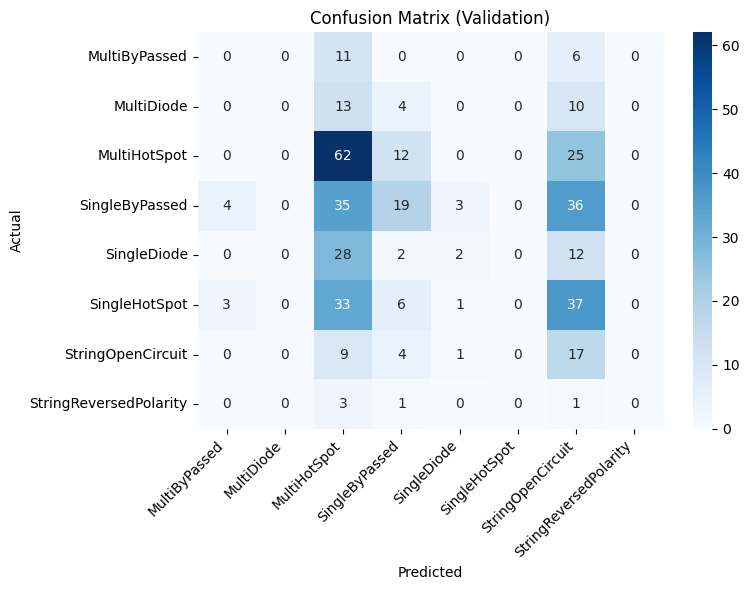

Classification report:

                        precision    recall  f1-score   support

         MultiByPassed     0.0000    0.0000    0.0000        17
            MultiDiode     0.0000    0.0000    0.0000        27
          MultiHotSpot     0.3196    0.6263    0.4232        99
        SingleByPassed     0.3958    0.1959    0.2621        97
           SingleDiode     0.2857    0.0455    0.0784        44
         SingleHotSpot     0.0000    0.0000    0.0000        80
     StringOpenCircuit     0.1181    0.5484    0.1943        31
StringReversedPolarity     0.0000    0.0000    0.0000         5

              accuracy                         0.2500       400
             macro avg     0.1399    0.1770    0.1197       400
          weighted avg     0.2157    0.2500    0.1920       400



In [17]:
# ---------------------------
# Cell 10: Confusion matrix & classification report
# ---------------------------
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Charger le meilleur modèle
if os.path.exists(best_path):
    ckpt = torch.load(best_path, map_location=DEVICE)
    model.load_state_dict(ckpt['model_state_dict'])
    print("Loaded checkpoint from", best_path)
else:
    print("No checkpoint found, using current model.")

model.eval()
all_preds = []
all_labels = []
all_names = CLASS_NAMES

with torch.no_grad():
    for imgs, labels, basenames in tqdm(valid_loader, desc="Final eval"):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(imgs)
        if isinstance(outputs, (tuple, list)):
            outputs = outputs[0]
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(NUM_CLASSES)))
plt.figure(figsize=(max(8, NUM_CLASSES), max(6, NUM_CLASSES*0.7)))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=all_names, yticklabels=all_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report
print("Classification report:\n")
print(classification_report(all_labels, all_preds, target_names=all_names, zero_division=0, digits=4))

Image: 2206_jpg.rf.4ea3fa309e7c039cf09a870c7f581259.jpg
Anomalie attendue : MultiHotSpot
Anomalie trouvée  : MultiHotSpot


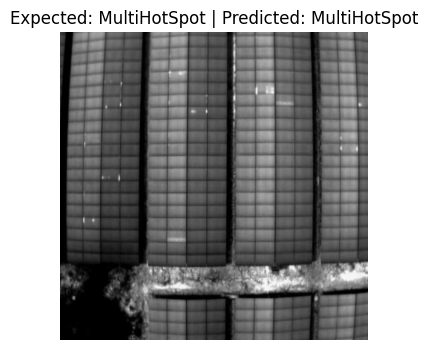

Top-k probabilities:
 - MultiHotSpot: 0.2183
 - StringOpenCircuit: 0.1775
 - SingleByPassed: 0.1456
 - MultiDiode: 0.1449
 - MultiByPassed: 0.1096


In [18]:
# ---------------------------
# Cell 11: Single image inference (Expected vs Found)
# ---------------------------
def preprocess_pil(img):
    # Applique le même transform que le dataset
    t = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[train_mean], std=[train_std]),
        transforms.Lambda(lambda t: t.repeat(3,1,1)),
    ])
    return t(img)

def expected_label_from_image_name(image_name, split="valid"):
    # image_name: ex "xxx.jpg"
    label_dir = os.path.join(DATASET_ROOT, split, "labels")
    label_path = os.path.join(label_dir, os.path.splitext(image_name)[0] + ".txt")
    boxes = load_yolo_labels(label_path)
    cid = choose_image_label(boxes)
    return cid

def predict_image(image_path):
    model.eval()
    img = Image.open(image_path)
    x = preprocess_pil(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        outputs = model(x)
        if isinstance(outputs, (tuple, list)):
            outputs = outputs[0]
        probs = torch.softmax(outputs, dim=1)
        pred_id = int(probs.argmax(dim=1).item())
        pred_name = CLASS_NAMES[pred_id]
        return pred_id, pred_name, probs.squeeze().cpu().numpy()

# Exemple d’utilisation:
# Indique le split et le nom de l'image présente dans ce split
SPLIT = "valid"  # "train", "valid" ou "test"
IMAGE_NAME = None  # ex: "image_123.jpg" ; si None, on en prend une au hasard

img_dir = os.path.join(DATASET_ROOT, SPLIT, "images")
choices = [os.path.basename(p) for p in glob.glob(os.path.join(img_dir, "*.*"))]
if not choices:
    print(f" No images found in {img_dir}")
else:
    if IMAGE_NAME is None:
        IMAGE_NAME = random.choice(choices)
    image_path = os.path.join(img_dir, IMAGE_NAME)
    pred_id, pred_name, probs = predict_image(image_path)

    exp_id = expected_label_from_image_name(IMAGE_NAME, split=SPLIT)
    exp_name = CLASS_NAMES[exp_id] if (exp_id is not None and 0 <= exp_id < NUM_CLASSES) else "Unknown"

    print(f"Image: {IMAGE_NAME}")
    print(f"Anomalie attendue : {exp_name}")
    print(f"Anomalie trouvée  : {pred_name}")

    # Afficher l'image et le top-5 des probabilités
    plt.figure(figsize=(6,4))
    plt.imshow(Image.open(image_path), cmap='gray')
    plt.axis('off')
    plt.title(f"Expected: {exp_name} | Predicted: {pred_name}")
    plt.show()

    # Top-k
    topk = 5 if NUM_CLASSES >= 5 else NUM_CLASSES
    top_ids = np.argsort(probs)[::-1][:topk]
    print("Top-k probabilities:")
    for i in top_ids:
        print(f" - {CLASS_NAMES[i]}: {probs[i]:.4f}")

In [19]:
# ---------------------------
# Cell 13: WeightedRandomSampler for class imbalance
# ---------------------------
from torch.utils.data import WeightedRandomSampler

# Calculer les poids par classe (déjà fait en Cellule 6 avec class_counts)
class_counts = class_counts_from_pairs(train_pairs, num_classes=NUM_CLASSES)
class_weights = 1.0 / (class_counts + 1e-8)  # inverse des fréquences

# Créer une liste de poids pour chaque échantillon du train_dataset
sample_weights = []
for _, label_path in train_pairs:
    boxes = load_yolo_labels(label_path)
    cid = choose_image_label(boxes)
    if cid is None or cid < 0 or cid >= NUM_CLASSES:
        cid = 0
    sample_weights.append(class_weights[cid])

sample_weights = torch.tensor(sample_weights, dtype=torch.double)

# Sampler pondéré
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Nouveau DataLoader avec sampler
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print("WeightedRandomSampler applied. Training loader ready.")

WeightedRandomSampler applied. Training loader ready.


In [20]:
# ---------------------------
# Cell 9.1: Training loop + validation + save best (new)
# ---------------------------
scaler = torch.amp.GradScaler("cuda", enabled=(DEVICE.type == "cuda"))

best_val_acc = 0.0
best_path = os.path.join(OUTPUT_DIR, "vim_tiny_best.pth")

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} - train")
    for imgs, labels, basenames in pbar:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        with torch.amp.autocast("cuda", enabled=(DEVICE.type == "cuda")):
            outputs = model(imgs)
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total += imgs.size(0)

        pbar.set_postfix(loss=running_loss / total, acc=running_corrects / total)

    epoch_loss = running_loss / total if total > 0 else 0.0
    epoch_acc = running_corrects / total if total > 0 else 0.0
    print(f"✅ Epoch {epoch} TRAIN Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    val_total = 0
    with torch.no_grad():
        for imgs, labels, basenames in tqdm(valid_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} - valid"):
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(imgs)
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            val_total += imgs.size(0)

    val_loss = val_loss / val_total if val_total > 0 else 0.0
    val_acc = val_corrects / val_total if val_total > 0 else 0.0
    print(f"📊 Epoch {epoch} VAL Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'class_names': CLASS_NAMES
        }, best_path)
        print(f"💾 Saved best model to {best_path} (val_acc={val_acc:.4f})")

    scheduler.step()

print("Training finished. Best val acc:", best_val_acc)

Epoch 1/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 1 TRAIN Loss: 2.3130 Acc: 0.1802


Epoch 1/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 1 VAL Loss: 2.1119 Acc: 0.2500
💾 Saved best model to /content/drive/MyDrive/thermal_model_outputs/vim_tiny_best.pth (val_acc=0.2500)


Epoch 2/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 2 TRAIN Loss: 2.0602 Acc: 0.2239


Epoch 2/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 2 VAL Loss: 2.0737 Acc: 0.1375


Epoch 3/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 3 TRAIN Loss: 1.3855 Acc: 0.2022


Epoch 3/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 3 VAL Loss: 2.4631 Acc: 0.0200


Epoch 4/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 4 TRAIN Loss: 1.0378 Acc: 0.2435


Epoch 4/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 4 VAL Loss: 2.5556 Acc: 0.0325


Epoch 5/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 5 TRAIN Loss: 0.7525 Acc: 0.3086


Epoch 5/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 5 VAL Loss: 3.0299 Acc: 0.0250


Epoch 6/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c36fca840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c36fca840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

✅ Epoch 6 TRAIN Loss: 0.5880 Acc: 0.3872


Epoch 6/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 6 VAL Loss: 2.7394 Acc: 0.0700


Epoch 7/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 7 TRAIN Loss: 0.4572 Acc: 0.4747


Epoch 7/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 7 VAL Loss: 2.8500 Acc: 0.1000


Epoch 8/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c36fca840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c36fca840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

✅ Epoch 8 TRAIN Loss: 0.3989 Acc: 0.5130


Epoch 8/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 8 VAL Loss: 2.8108 Acc: 0.1325


Epoch 9/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 9 TRAIN Loss: 0.2658 Acc: 0.5981


Epoch 9/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 9 VAL Loss: 2.9415 Acc: 0.1600


Epoch 10/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 10 TRAIN Loss: 0.2853 Acc: 0.6021


Epoch 10/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 10 VAL Loss: 2.8912 Acc: 0.1675


Epoch 11/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c36fca840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c36fca840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

✅ Epoch 11 TRAIN Loss: 0.1906 Acc: 0.6636


Epoch 11/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 11 VAL Loss: 3.2036 Acc: 0.1725


Epoch 12/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 12 TRAIN Loss: 0.1841 Acc: 0.6908


Epoch 12/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 12 VAL Loss: 3.3372 Acc: 0.1875
Training finished. Best val acc: 0.25


Loaded checkpoint from /content/drive/MyDrive/thermal_model_outputs/vim_tiny_best.pth


Final eval:   0%|          | 0/25 [00:00<?, ?it/s]

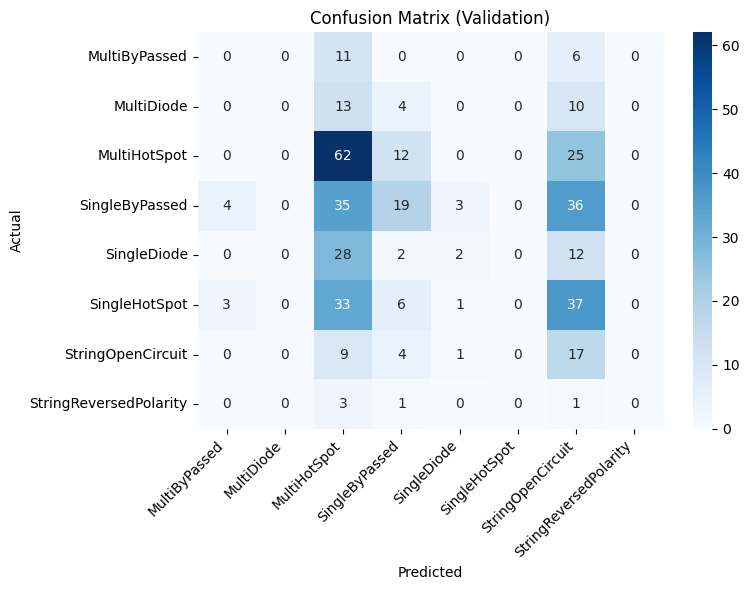

Classification report:

                        precision    recall  f1-score   support

         MultiByPassed     0.0000    0.0000    0.0000        17
            MultiDiode     0.0000    0.0000    0.0000        27
          MultiHotSpot     0.3196    0.6263    0.4232        99
        SingleByPassed     0.3958    0.1959    0.2621        97
           SingleDiode     0.2857    0.0455    0.0784        44
         SingleHotSpot     0.0000    0.0000    0.0000        80
     StringOpenCircuit     0.1181    0.5484    0.1943        31
StringReversedPolarity     0.0000    0.0000    0.0000         5

              accuracy                         0.2500       400
             macro avg     0.1399    0.1770    0.1197       400
          weighted avg     0.2157    0.2500    0.1920       400



In [21]:
# ---------------------------
# Cell 10.1: Confusion matrix & classification report (new)
# ---------------------------
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Charger le meilleur modèle
if os.path.exists(best_path):
    ckpt = torch.load(best_path, map_location=DEVICE)
    model.load_state_dict(ckpt['model_state_dict'])
    print("Loaded checkpoint from", best_path)
else:
    print("No checkpoint found, using current model.")

model.eval()
all_preds = []
all_labels = []
all_names = CLASS_NAMES

with torch.no_grad():
    for imgs, labels, basenames in tqdm(valid_loader, desc="Final eval"):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(imgs)
        if isinstance(outputs, (tuple, list)):
            outputs = outputs[0]
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(NUM_CLASSES)))
plt.figure(figsize=(max(8, NUM_CLASSES), max(6, NUM_CLASSES*0.7)))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=all_names, yticklabels=all_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report
print("Classification report:\n")
print(classification_report(all_labels, all_preds, target_names=all_names, zero_division=0, digits=4))

In [22]:
# ---------------------------
# Cell 14: Data augmentation
# ---------------------------
from torchvision import transforms

# Transforms avec augmentation
augment_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(p=0.5),       # flip horizontal
    transforms.RandomVerticalFlip(p=0.5),         # flip vertical
    transforms.RandomRotation(degrees=15),        # rotation ±15°
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # jitter contraste/luminosité
    transforms.ToTensor(),
    transforms.Normalize(mean=[train_mean], std=[train_std]),
    transforms.Lambda(lambda t: t.repeat(3,1,1)), # répéter en 3 canaux
])

# Dataset avec augmentation pour le train
train_dataset = SolarPanelDataset(train_pairs, transform=augment_transform)

# Validation et test restent sans augmentation (transform normal)
valid_dataset = SolarPanelDataset(valid_pairs, transform=transform)
test_dataset  = SolarPanelDataset(test_pairs,  transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("Data augmentation applied to training dataset.")

Data augmentation applied to training dataset.


In [23]:
# ---------------------------
# Cell 9.1: Training loop + validation + save best (new)
# ---------------------------
scaler = torch.amp.GradScaler("cuda", enabled=(DEVICE.type == "cuda"))

best_val_acc = 0.0
best_path = os.path.join(OUTPUT_DIR, "vim_tiny_best.pth")

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} - train")
    for imgs, labels, basenames in pbar:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        with torch.amp.autocast("cuda", enabled=(DEVICE.type == "cuda")):
            outputs = model(imgs)
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total += imgs.size(0)

        pbar.set_postfix(loss=running_loss / total, acc=running_corrects / total)

    epoch_loss = running_loss / total if total > 0 else 0.0
    epoch_acc = running_corrects / total if total > 0 else 0.0
    print(f"✅ Epoch {epoch} TRAIN Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    val_total = 0
    with torch.no_grad():
        for imgs, labels, basenames in tqdm(valid_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} - valid"):
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(imgs)
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            val_total += imgs.size(0)

    val_loss = val_loss / val_total if val_total > 0 else 0.0
    val_acc = val_corrects / val_total if val_total > 0 else 0.0
    print(f"📊 Epoch {epoch} VAL Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'class_names': CLASS_NAMES
        }, best_path)
        print(f"💾 Saved best model to {best_path} (val_acc={val_acc:.4f})")

    scheduler.step()

print("Training finished. Best val acc:", best_val_acc)

Epoch 1/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 1 TRAIN Loss: 2.0377 Acc: 0.2376


Epoch 1/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 1 VAL Loss: 2.0609 Acc: 0.1550
💾 Saved best model to /content/drive/MyDrive/thermal_model_outputs/vim_tiny_best.pth (val_acc=0.1550)


Epoch 2/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 2 TRAIN Loss: 2.0276 Acc: 0.2488


Epoch 2/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 2 VAL Loss: 2.0995 Acc: 0.2675
💾 Saved best model to /content/drive/MyDrive/thermal_model_outputs/vim_tiny_best.pth (val_acc=0.2675)


Epoch 3/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 3 TRAIN Loss: 2.0151 Acc: 0.2691


Epoch 3/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 3 VAL Loss: 2.0781 Acc: 0.2550


Epoch 4/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 4 TRAIN Loss: 2.0185 Acc: 0.2688


Epoch 4/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 4 VAL Loss: 2.0717 Acc: 0.2700
💾 Saved best model to /content/drive/MyDrive/thermal_model_outputs/vim_tiny_best.pth (val_acc=0.2700)


Epoch 5/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 5 TRAIN Loss: 2.0096 Acc: 0.2773


Epoch 5/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 5 VAL Loss: 2.0875 Acc: 0.2550


Epoch 6/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 6 TRAIN Loss: 1.9982 Acc: 0.2773


Epoch 6/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 6 VAL Loss: 2.1153 Acc: 0.2425


Epoch 7/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 7 TRAIN Loss: 1.9918 Acc: 0.2800


Epoch 7/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 7 VAL Loss: 2.0487 Acc: 0.1550


Epoch 8/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c36fca840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c36fca840>    
if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
     self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive(): 
  ^   ^ ^ ^ ^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'

    File "/usr/lib/pyth

✅ Epoch 8 TRAIN Loss: 1.9862 Acc: 0.2647


Epoch 8/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 8 VAL Loss: 2.0597 Acc: 0.2075


Epoch 9/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c36fca840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
          Exception ignored in:  ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c36fca840>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^ ^^  ^^ ^^^^^^^^

✅ Epoch 9 TRAIN Loss: 1.9696 Acc: 0.2760


Epoch 9/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 9 VAL Loss: 2.0621 Acc: 0.2325


Epoch 10/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 10 TRAIN Loss: 1.9595 Acc: 0.3034


Epoch 10/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 10 VAL Loss: 2.0678 Acc: 0.1950


Epoch 11/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 11 TRAIN Loss: 1.9590 Acc: 0.2821


Epoch 11/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 11 VAL Loss: 2.0603 Acc: 0.1900


Epoch 12/12 - train:   0%|          | 0/433 [00:00<?, ?it/s]

✅ Epoch 12 TRAIN Loss: 1.9469 Acc: 0.2798


Epoch 12/12 - valid:   0%|          | 0/25 [00:00<?, ?it/s]

📊 Epoch 12 VAL Loss: 2.0561 Acc: 0.1925
Training finished. Best val acc: 0.27


Loaded checkpoint from /content/drive/MyDrive/thermal_model_outputs/vim_tiny_best.pth


Final eval:   0%|          | 0/25 [00:00<?, ?it/s]

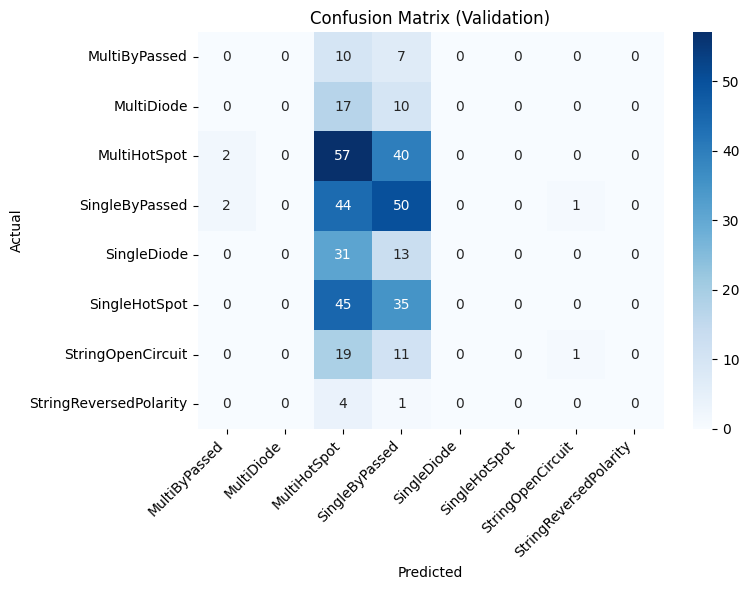

Classification report:

                        precision    recall  f1-score   support

         MultiByPassed     0.0000    0.0000    0.0000        17
            MultiDiode     0.0000    0.0000    0.0000        27
          MultiHotSpot     0.2511    0.5758    0.3497        99
        SingleByPassed     0.2994    0.5155    0.3788        97
           SingleDiode     0.0000    0.0000    0.0000        44
         SingleHotSpot     0.0000    0.0000    0.0000        80
     StringOpenCircuit     0.5000    0.0323    0.0606        31
StringReversedPolarity     0.0000    0.0000    0.0000         5

              accuracy                         0.2700       400
             macro avg     0.1313    0.1404    0.0986       400
          weighted avg     0.1735    0.2700    0.1831       400



In [24]:
# ---------------------------
# Cell 10.1: Confusion matrix & classification report (new)
# ---------------------------
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Charger le meilleur modèle
if os.path.exists(best_path):
    ckpt = torch.load(best_path, map_location=DEVICE)
    model.load_state_dict(ckpt['model_state_dict'])
    print("Loaded checkpoint from", best_path)
else:
    print("No checkpoint found, using current model.")

model.eval()
all_preds = []
all_labels = []
all_names = CLASS_NAMES

with torch.no_grad():
    for imgs, labels, basenames in tqdm(valid_loader, desc="Final eval"):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(imgs)
        if isinstance(outputs, (tuple, list)):
            outputs = outputs[0]
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(NUM_CLASSES)))
plt.figure(figsize=(max(8, NUM_CLASSES), max(6, NUM_CLASSES*0.7)))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=all_names, yticklabels=all_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report
print("Classification report:\n")
print(classification_report(all_labels, all_preds, target_names=all_names, zero_division=0, digits=4))